Scalar version: https://github.com/genkuroki/public/blob/main/0018/HMC%20leapfrog.ipynb

In [1]:
module My

using LinearAlgebra
using ConcreteStructs: @concrete
using ForwardDiff: gradient
using Parameters: @unpack
using Random: default_rng, randn!
using StaticArrays

@concrete struct LFProblem{dim} ϕ; H; F; dt; nsteps end

"""ϕ should be a potential function."""
function LFProblem(dim, ϕ; dt = 1.0, nsteps = 40)
    H(x, v, param) = dot(v, v)/2 + ϕ(x, param)
    F(x, param) = -gradient(x -> ϕ(x, param), x)
    LFProblem{dim}(ϕ, H, F, dt, nsteps)
end

"""Numerically solve Hamilton's equation of motion with leapfrog method"""
function solve(lf::LFProblem, x, v, param)
    @unpack F, dt, nsteps = lf
    v = v + F(x, param)*dt/2
    x = x + v*dt
    for _ in 2:nsteps
        v = v + F(x, param)*dt
        x = x + v*dt
    end
    v = v + F(x, param)*dt/2
    x, v
end

function _update!(lf::LFProblem{dim}, x, vtmp, param, rng) where dim
    @unpack H = lf
    v = SVector{dim}(randn!(rng, vtmp))
    xnew, vnew = solve(lf, x, v, param)
    dH = H(xnew, vnew, param) - H(x, v, param)
    alpha = min(1, exp(-dH))
    rand(rng) ≤ alpha ? xnew : x
end

"""Hamiltonian Monte Carlo"""
function HMC(lf::LFProblem{dim}, param = nothing; niters = 10^5, burnin = 0, rng = default_rng(),
        x0 = SVector{dim}(randn(rng, dim))) where dim
    @unpack H = lf
    vtmp = MVector{dim}(zeros(eltype(x0), dim))
    x = x0
    for _ in 1:burnin
        x = _update!(lf, x, vtmp, param, rng)
    end
    sample = Vector{typeof(x0)}(undef, niters)
    for i in 1:niters
        x = _update!(lf, x, vtmp, param, rng)
        sample[i] = x
    end
    sample
end

end

Main.My

In [2]:
using Plots
using BenchmarkTools
using StaticArrays
using LinearAlgebra
using KernelDensity
using Statistics

In [3]:
A = @SMatrix [
     1  1/2
    1/2  1
]
param = (; A = A)
ϕ(x, param) = dot(x, param.A, x)/2
lf = My.LFProblem(2, ϕ)

Main.My.LFProblem{2, typeof(ϕ), Main.My.var"#H#3"{typeof(ϕ)}, Main.My.var"#F#4"{typeof(ϕ)}, Float64, Int64}(ϕ, Main.My.var"#H#3"{typeof(ϕ)}(ϕ), Main.My.var"#F#4"{typeof(ϕ)}(ϕ), 1.0, 40)

In [4]:
@time sample = My.HMC(lf, param)
@time sample = My.HMC(lf, param)
@time sample = My.HMC(lf, param);

  0.736636 seconds (1.99 M allocations: 124.541 MiB, 3.62% gc time, 92.13% compilation time)
  0.057746 seconds (5 allocations: 1.526 MiB)
  0.061033 seconds (5 allocations: 1.526 MiB)


In [5]:
@btime My.HMC($lf, $param);

  54.280 ms (5 allocations: 1.53 MiB)


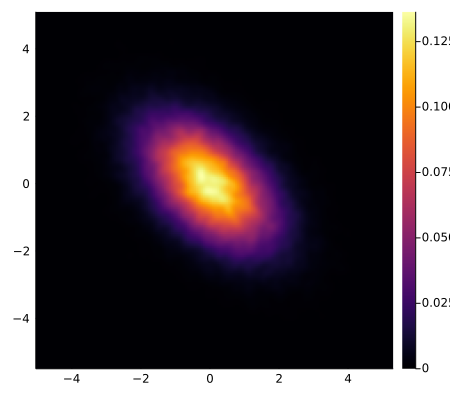

In [6]:
X, Y = first.(sample), last.(sample)
d = InterpKDE(kde((X, Y)))
x, y = range(extrema(X)...; length=201), range(extrema(Y)...; length=201)
heatmap(x, y, (x, y) -> pdf(d, x, y); size=(450, 400))

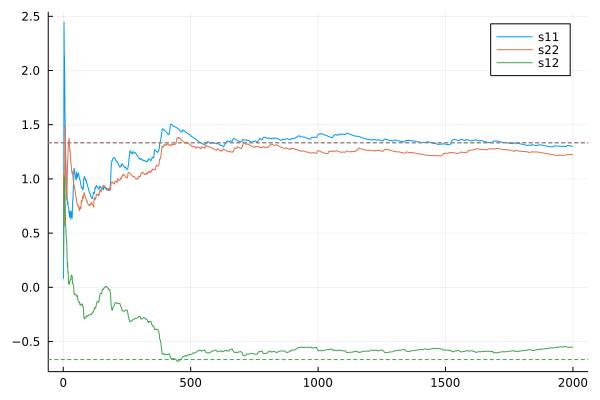

In [7]:
f(n) = mean(x -> x*x', @view sample[1:n])

n = 1:2000
S = f.(n)
S11 = (S -> S[1,1]).(S)
S22 = (S -> S[2,2]).(S)
S12 = (S -> S[1,2]).(S)

plot()
plot!(S11; label="s11", c=1)
hline!([inv(A)[1,1]]; label="", c=1, ls=:dash)
plot!(S22; label="s22", c=2)
hline!([inv(A)[2,2]]; label="", c=2, ls=:dash)
plot!(S12; label="s12", c=3)
hline!([inv(A)[1,2]]; label="", c=3, ls=:dash)